In [10]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import KFold


from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures,MinMaxScaler
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

SEED=42
cpu=-1
datasetFolder=os.path.dirname(os.path.dirname(os.getcwd()))

def predict_score(model,x_train,y_train,x_test,y_test,name):
    model.fit(x_train,y_train)
    best_pipe=model.best_estimator_
    poly=best_pipe.named_steps["polynomial_features"]
    poly_features=poly.get_feature_names_out(list(x_train.columns))
    selector=best_pipe.named_steps["feature_selection"]
    select_indices=selector.get_support(1)
    select_features=poly_features[select_indices]
    y_predict=model.predict(x_test)
    f1=f1_score(y_test,y_predict)
    auc_score=roc_auc_score(y_test,y_predict)
    a=1
    return f1,auc_score,select_features
    
def baseDataSet(methodFile):
    df=pd.read_csv(methodFile,encoding_errors="replace")
    df=df.dropna(how="any")
    df=df[['fanin_x', 'fanout_x', 'wmc_x', 'loc_x', 'returnsQty_x', 'variablesQty_x', 'parametersQty_x', 'loopQty_x', 'anonymousClassesQty_x', 'innerClassesQty_x',"FeatureEnvy"]]
    x=df.drop(columns="FeatureEnvy")
    y=df[["FeatureEnvy"]]
    return x,y

def addMetricsDataSet(methodFile):
    df=pd.read_csv(methodFile,encoding_errors="replace")
    df=df.dropna(how="any")
    df=df[['fanin_x', 'fanout_x', 'wmc_x', 'loc_x', 'returnsQty_x', 'variablesQty_x', 'parametersQty_x', 'loopQty_x', 'anonymousClassesQty_x', 'innerClassesQty_x', 'ATFD_x', 'ATLD_x', 'LAA_x',"FeatureEnvy"]]
    x=df.drop(columns="FeatureEnvy")
    y=df[["FeatureEnvy"]]
    return x,y

def baseVersionDataSet(methodFile):
    df=pd.read_csv(methodFile,encoding_errors="replace")
    df=df.dropna(how="any")
    df=df[['fanin_x', 'fanout_x', 'wmc_x', 'loc_x', 'returnsQty_x', 'variablesQty_x', 'parametersQty_x', 'loopQty_x', 'anonymousClassesQty_x', 'innerClassesQty_x','fanin_y', 'fanout_y', 'wmc_y', 'loc_y', 'returnsQty_y', 'variablesQty_y', 'parametersQty_y', 'loopQty_y', 'anonymousClassesQty_y', 'innerClassesQty_y',"FeatureEnvy"]]
    factors=["fanin","fanout","wmc","loc","returnsQty","variablesQty","parametersQty","loopQty","anonymousClassesQty","innerClassesQty"]
    for factor in factors:
        df[factor+"_y"]=df[factor+"_x"]-df[factor+"_y"]
    x=df.drop(columns="FeatureEnvy")
    y=df[["FeatureEnvy"]]
    return x,y

def addMetricsVersionDataSet(methodFile):
    df=pd.read_csv(methodFile,encoding_errors="replace")
    df=df.dropna(how="any")
    df=df[['fanin_x', 'fanout_x', 'wmc_x', 'loc_x', 'returnsQty_x', 'variablesQty_x', 'parametersQty_x', 'loopQty_x', 'anonymousClassesQty_x', 'innerClassesQty_x', 'ATFD_x', 'ATLD_x', 'LAA_x',  'fanin_y', 'fanout_y', 'wmc_y', 'loc_y', 'returnsQty_y', 'variablesQty_y', 'parametersQty_y', 'loopQty_y', 'anonymousClassesQty_y', 'innerClassesQty_y', 'ATFD_y', 'ATLD_y', 'LAA_y',"FeatureEnvy"]]
    factors=["fanin","fanout","wmc","loc","returnsQty","variablesQty","parametersQty","loopQty","anonymousClassesQty","innerClassesQty","ATFD","ATLD","LAA"]
    for factor in factors:
        df[factor+"_y"]=df[factor+"_x"]-df[factor+"_y"]
    x=df.drop(columns="FeatureEnvy")
    y=df[["FeatureEnvy"]]
    return x,y



def overSampling(x_train,y_train):
    x_sampling,y_sampling=SMOTE(sampling_strategy=0.2,random_state=SEED).fit_resample(x_train,y_train)
    return x_sampling,y_sampling

def createTrainTestData(x,y):
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=SEED)
    x_TrainSampling,y_TrainSampling=overSampling(x_train,y_train)
    return x_TrainSampling,x_test,y_TrainSampling,y_test

In [11]:
FeatureEnvyFile=os.path.join(datasetFolder,"dataset2\\FeatureEnvy.csv")

x_base,y_base=baseDataSet(FeatureEnvyFile)
x_base_train,x_base_test,y_base_train,y_base_test=createTrainTestData(x_base,y_base)
base_score={"f1":[],"auc":[],"feature":[]}

x_add,y_add=addMetricsDataSet(FeatureEnvyFile)
x_add_train,x_add_test,y_add_train,y_add_test=createTrainTestData(x_add,y_add)
add_score={"f1":[],"auc":[],"feature":[]}
print(x_add.head())

x_baseVersion,y_baseVersion=baseVersionDataSet(FeatureEnvyFile)
x_baseVersion_train,x_baseVersion_test,y_baseVersion_train,y_baseVersion_test=createTrainTestData(x_baseVersion,y_baseVersion)
baseVersion_score={"f1":[],"auc":[],"feature":[]}

x_addVersion,y_addVersion=addMetricsVersionDataSet(FeatureEnvyFile)
x_addVersion_train,x_addVersion_test,y_addVersion_train,y_addVersion_test=createTrainTestData(x_addVersion,y_addVersion)
addVersion_score={"f1":[],"auc":[],"feature":[]}


   fanin_x  fanout_x  wmc_x  loc_x  returnsQty_x  variablesQty_x  \
0        2         0      1      3             1               0   
1        2         1      1      3             1               0   
2        1         1      2      7             1               1   
3        0         2      2     10             1               4   
4        1         0      1      3             1               0   

   parametersQty_x  loopQty_x  anonymousClassesQty_x  innerClassesQty_x  \
0                0          0                      0                  0   
1                0          0                      0                  0   
2                1          0                      0                  0   
3                1          0                      0                  0   
4                1          0                      0                  0   

   ATFD_x  ATLD_x  LAA_x  
0       0       1    1.0  
1       1       0    0.0  
2       1       0    0.0  
3       4       0    0.0  
4    

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

name="RF"
RF_prameter={    
    'classifier__n_estimators': [100, 200, 300, 400, 500],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [None, 5, 10, 15, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['auto', 'sqrt', 'log2']
    }


k_range=np.arange(1,11,1)
for i in k_range:
    pipline=Pipeline([
        ("polynomial_features",PolynomialFeatures(degree=2)),
        ("minmaxscaler",MinMaxScaler()),
        ("feature_selection",SelectKBest(score_func=f_classif,k=i)),
        ("classifier",RandomForestClassifier(random_state=SEED))
    ])
    model=RandomizedSearchCV(pipline, param_distributions=RF_prameter,cv=KFold(n_splits=10,shuffle=True,random_state=SEED),random_state=SEED,n_jobs=cpu)
    print(str(i))
    f1_base,auc_base,feature_base=predict_score(model,x_base_train,y_base_train,x_base_test,y_base_test,name)
    base_score["f1"].append(f1_base)
    base_score["auc"].append(auc_base)
    base_score["feature"].append(feature_base)
    
    f1_add,auc_add,feature_add=predict_score(model,x_add_train,y_add_train,x_add_test,y_add_test,name)
    add_score["f1"].append(f1_add)
    add_score["auc"].append(auc_add)
    add_score["feature"].append(feature_add)
    
    f1_baseVersion,auc_baseVersion,feature_baseVersion=predict_score(model,x_baseVersion_train,y_baseVersion_train,x_baseVersion_test,y_baseVersion_test,name)
    baseVersion_score["f1"].append(f1_baseVersion)
    baseVersion_score["auc"].append(auc_baseVersion)
    baseVersion_score["feature"].append(feature_baseVersion)

    f1_addVersion,auc_addVersion,feature_addVersion=predict_score(model,x_addVersion_train,y_addVersion_train,x_addVersion_test,y_addVersion_test,name)
    addVersion_score["f1"].append(f1_addVersion)
    addVersion_score["auc"].append(auc_addVersion)   
    addVersion_score["feature"].append(feature_addVersion)

    #features_baselist.append(baseDF.columns[features_base])
    #features_addlist.append(addMetricsDF.columns[features_add])


1


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py:490: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
14 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py", line 833, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundat

2


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py:490: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
17 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py", line 833, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundat

3


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py:490: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py", line 833, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundati

4


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py:490: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py", line 833, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundat

5


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py:490: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py", line 833, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundat

6


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py:490: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py", line 833, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundat

7


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py:490: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py", line 833, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundati

8


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py:490: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py", line 833, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundati

9


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py:490: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py", line 833, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundati

10


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py:490: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py", line 833, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundat

base
f1 :  0.08403361344537816
auc_score :  0.6275663806958371
Index(['dit_x', 'fanin_x', 'fanout_x', 'rfc_x', 'wmc_x'], dtype='object')

addMetrics
f1 :  0.10569105691056911
auc_score :  0.6700273898182312
Index(['dit_x', 'fanout_x', 'rfc_x', 'BOvR_x', 'BUR_x'], dtype='object')

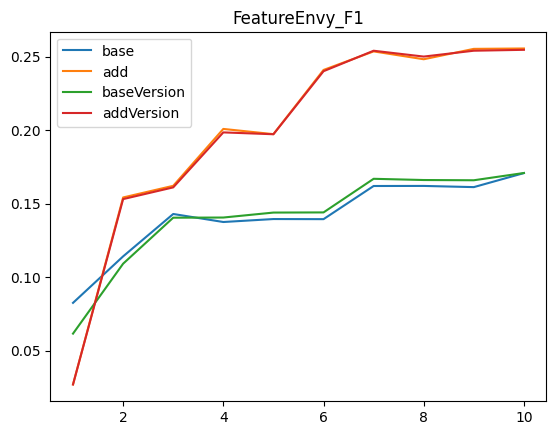

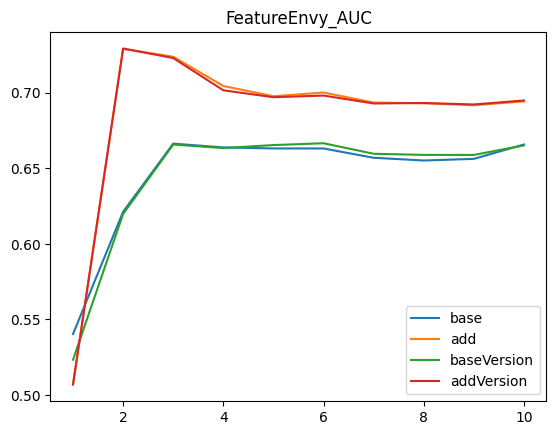

In [13]:
import matplotlib.pyplot as plt

x=k_range
plt.title("FeatureEnvy_F1")
plt.plot(x,base_score["f1"],label="base")
plt.plot(x,add_score["f1"],label="add")
plt.plot(x,baseVersion_score["f1"],label="baseVersion")
plt.plot(x,addVersion_score["f1"],label="addVersion")
plt.legend()
plt.show()

plt.title("FeatureEnvy_AUC")
plt.plot(x,base_score["auc"],label="base")
plt.plot(x,add_score["auc"],label="add")
plt.plot(x,baseVersion_score["auc"],label="baseVersion")
plt.plot(x,addVersion_score["auc"],label="addVersion")
plt.legend()
plt.show()

In [14]:
print("base : ",base_score)
print("add : ",add_score)
print("baseVersion : ",baseVersion_score)
print("addVersion : ",addVersion_score)

base :  {'f1': [0.08242424242424243, 0.11404728789986092, 0.14289494575284467, 0.13743589743589743, 0.13944954128440368, 0.1393764736704218, 0.16193274567417565, 0.16198347107438016, 0.16117455138662318, 0.17071569271175313], 'auc': [0.540329180101377, 0.6212104664408792, 0.6662381099460669, 0.6637120011976596, 0.6630410129420297, 0.6630230020634591, 0.6568850479306523, 0.6550725787311706, 0.6561488117546401, 0.6656568439677992], 'feature': [array(['variablesQty_x'], dtype=object), array(['loc_x', 'variablesQty_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loc_x parametersQty_x'],
      dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x',
       'loc_x parametersQty_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x',
       'loc_x parametersQty_x', 'variablesQty_x parametersQty_x'],
      dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x',
       'fa

In [15]:
for i in k_range:
    print("base : ",base_score["feature"][i])
    print("add : ",add_score["feature"][i])
    print("baseVersion : ",baseVersion_score["feature"][i])
    print("addVersion : ",addVersion_score["feature"][i])

base :  ['loc_x' 'variablesQty_x']
add :  ['ATFD_x' 'LAA_x^2']
baseVersion :  ['loc_x' 'variablesQty_x']
addVersion :  ['ATFD_x' 'LAA_x^2']
base :  ['wmc_x' 'loc_x' 'variablesQty_x']
add :  ['variablesQty_x' 'ATFD_x' 'LAA_x^2']
baseVersion :  ['wmc_x' 'loc_x' 'variablesQty_x']
addVersion :  ['variablesQty_x' 'ATFD_x' 'LAA_x^2']
base :  ['wmc_x' 'loc_x' 'variablesQty_x' 'loc_x parametersQty_x']
add :  ['loc_x' 'variablesQty_x' 'ATFD_x' 'LAA_x^2']
baseVersion :  ['wmc_x' 'loc_x' 'variablesQty_x' 'loc_x parametersQty_x']
addVersion :  ['loc_x' 'variablesQty_x' 'ATFD_x' 'LAA_x^2']
base :  ['wmc_x' 'loc_x' 'variablesQty_x' 'loopQty_x' 'loc_x parametersQty_x']
add :  ['loc_x' 'variablesQty_x' 'ATFD_x' 'ATFD_x LAA_x' 'LAA_x^2']
baseVersion :  ['wmc_x' 'loc_x' 'variablesQty_x' 'loopQty_x' 'loc_x parametersQty_x']
addVersion :  ['loc_x' 'variablesQty_x' 'ATFD_x' 'ATFD_x LAA_x' 'LAA_x^2']
base :  ['wmc_x' 'loc_x' 'variablesQty_x' 'loopQty_x' 'loc_x parametersQty_x'
 'variablesQty_x parametersQty

IndexError: list index out of range

base :  {'f1': [0.08242424242424243, 0.11404728789986092, 0.14289494575284467, 0.13743589743589743, 0.13944954128440368, 0.1393764736704218, 0.16193274567417565, 0.16198347107438016, 0.16117455138662318, 0.17071569271175313], 'auc': [0.540329180101377, 0.6212104664408792, 0.6662381099460669, 0.6637120011976596, 0.6630410129420297, 0.6630230020634591, 0.6568850479306523, 0.6550725787311706, 0.6561488117546401, 0.6656568439677992], 'feature': [array(['variablesQty_x'], dtype=object), array(['loc_x', 'variablesQty_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loc_x parametersQty_x'],
      dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x',
       'loc_x parametersQty_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x',
       'loc_x parametersQty_x', 'variablesQty_x parametersQty_x'],
      dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x',
       'fanout_x variablesQty_x', 'loc_x parametersQty_x',
       'variablesQty_x parametersQty_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x',
       'fanout_x variablesQty_x', 'wmc_x parametersQty_x',
       'loc_x parametersQty_x', 'variablesQty_x parametersQty_x'],
      dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x',
       'fanout_x variablesQty_x', 'wmc_x parametersQty_x',
       'loc_x parametersQty_x', 'variablesQty_x^2',
       'variablesQty_x parametersQty_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x', 'fanout_x loc_x',
       'fanout_x variablesQty_x', 'wmc_x parametersQty_x',
       'loc_x parametersQty_x', 'variablesQty_x^2',
       'variablesQty_x parametersQty_x'], dtype=object)]}
add :  {'f1': [0.026915113871635612, 0.15413455530097897, 0.16206428248076052, 0.20076481835564053, 0.19721952796637568, 0.24089635854341737, 0.2535087719298246, 0.24817518248175183, 0.25524319500223114, 0.2555066079295154], 'auc': [0.5069865092132668, 0.7288570807405972, 0.7236874604175816, 0.7043307349128234, 0.6975537267062498, 0.7000300564519694, 0.69338354408616, 0.6929422775611789, 0.6915800803259636, 0.6941918237764546], 'feature': [array(['LAA_x^2'], dtype=object), array(['ATFD_x', 'LAA_x^2'], dtype=object), array(['variablesQty_x', 'ATFD_x', 'LAA_x^2'], dtype=object), array(['loc_x', 'variablesQty_x', 'ATFD_x', 'LAA_x^2'], dtype=object), array(['loc_x', 'variablesQty_x', 'ATFD_x', 'ATFD_x LAA_x', 'LAA_x^2'],
      dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'ATFD_x', 'ATFD_x LAA_x',
       'LAA_x^2'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'ATFD_x',
       'loc_x parametersQty_x', 'ATFD_x LAA_x', 'LAA_x^2'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'ATFD_x',
       'loc_x parametersQty_x', 'parametersQty_x ATFD_x', 'ATFD_x LAA_x',
       'LAA_x^2'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x', 'ATFD_x',
       'loc_x parametersQty_x', 'parametersQty_x ATFD_x', 'ATFD_x LAA_x',
       'LAA_x^2'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x', 'ATFD_x',
       'loc_x parametersQty_x', 'variablesQty_x parametersQty_x',
       'parametersQty_x ATFD_x', 'ATFD_x LAA_x', 'LAA_x^2'], dtype=object)]}
baseVersion :  {'f1': [0.061491160645657184, 0.10907156158552807, 0.14036911879386535, 0.14048059149722736, 0.1438539989264627, 0.14396161023727005, 0.16683283482884678, 0.16600265604249667, 0.16583747927031509, 0.17078799868117375], 'auc': [0.5233617700835986, 0.6197335743980853, 0.6656257400746646, 0.6632931652420189, 0.6652789476333067, 0.6664902622460561, 0.659526017544384, 0.6587807759290868, 0.6587537596112307, 0.6650556893810671], 'feature': [array(['variablesQty_x'], dtype=object), array(['loc_x', 'variablesQty_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loc_x parametersQty_x'],
      dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x',
       'loc_x parametersQty_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x',
       'loc_x parametersQty_x', 'variablesQty_x parametersQty_x'],
      dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x',
       'fanout_x variablesQty_x', 'loc_x parametersQty_x',
       'variablesQty_x parametersQty_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x',
       'fanout_x variablesQty_x', 'wmc_x parametersQty_x',
       'loc_x parametersQty_x', 'variablesQty_x parametersQty_x'],
      dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x',
       'fanout_x variablesQty_x', 'wmc_x parametersQty_x',
       'loc_x parametersQty_x', 'variablesQty_x^2',
       'variablesQty_x parametersQty_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x', 'fanout_x loc_x',
       'fanout_x variablesQty_x', 'wmc_x parametersQty_x',
       'loc_x parametersQty_x', 'variablesQty_x^2',
       'variablesQty_x parametersQty_x'], dtype=object)]}
addVersion :  {'f1': [0.02688728024819028, 0.15302124149309135, 0.16099210822998872, 0.19840510366826156, 0.19714656290531776, 0.2400322190898107, 0.25396825396825395, 0.25, 0.25398230088495577, 0.2545931758530184], 'auc': [0.5069775037739817, 0.7291430449523428, 0.7228161426522897, 0.7014848500409141, 0.6969165503623763, 0.6980194675882104, 0.6927733840601424, 0.6930953700290295, 0.6921272022769839, 0.6947659620453307], 'feature': [array(['LAA_x^2'], dtype=object), array(['ATFD_x', 'LAA_x^2'], dtype=object), array(['variablesQty_x', 'ATFD_x', 'LAA_x^2'], dtype=object), array(['loc_x', 'variablesQty_x', 'ATFD_x', 'LAA_x^2'], dtype=object), array(['loc_x', 'variablesQty_x', 'ATFD_x', 'ATFD_x LAA_x', 'LAA_x^2'],
      dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'ATFD_x', 'ATFD_x LAA_x',
       'LAA_x^2'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'ATFD_x',
       'loc_x parametersQty_x', 'ATFD_x LAA_x', 'LAA_x^2'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'ATFD_x',
       'loc_x parametersQty_x', 'parametersQty_x ATFD_x', 'ATFD_x LAA_x',
       'LAA_x^2'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x', 'ATFD_x',
       'loc_x parametersQty_x', 'parametersQty_x ATFD_x', 'ATFD_x LAA_x',
       'LAA_x^2'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x', 'ATFD_x',
       'loc_x parametersQty_x', 'variablesQty_x parametersQty_x',
       'parametersQty_x ATFD_x', 'ATFD_x LAA_x', 'LAA_x^2'], dtype=object)]}


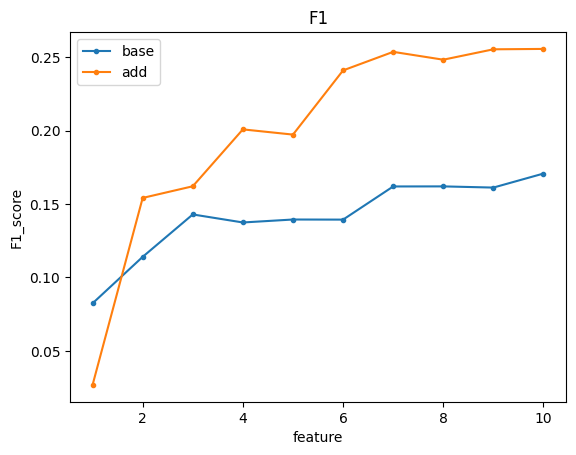

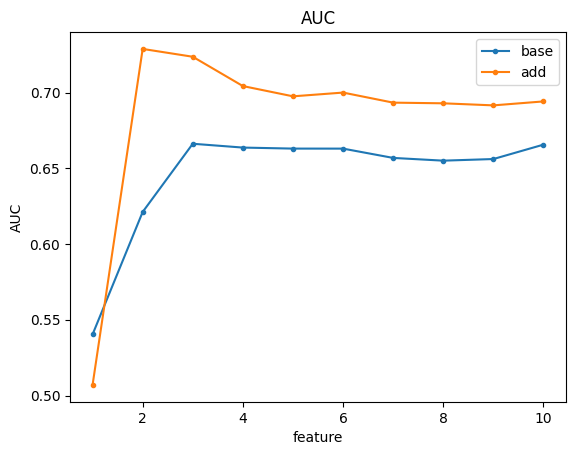

In [1]:
import numpy as np
import matplotlib.pyplot as plt
base_score={'f1': [0.08242424242424243, 0.11404728789986092, 0.14289494575284467, 0.13743589743589743, 0.13944954128440368, 0.1393764736704218, 0.16193274567417565, 0.16198347107438016, 0.16117455138662318, 0.17071569271175313], 'auc': [0.540329180101377, 0.6212104664408792, 0.6662381099460669, 0.6637120011976596, 0.6630410129420297, 0.6630230020634591, 0.6568850479306523, 0.6550725787311706, 0.6561488117546401, 0.6656568439677992]}
add_score={'f1': [0.026915113871635612, 0.15413455530097897, 0.16206428248076052, 0.20076481835564053, 0.19721952796637568, 0.24089635854341737, 0.2535087719298246, 0.24817518248175183, 0.25524319500223114, 0.2555066079295154], 'auc': [0.5069865092132668, 0.7288570807405972, 0.7236874604175816, 0.7043307349128234, 0.6975537267062498, 0.7000300564519694, 0.69338354408616, 0.6929422775611789, 0.6915800803259636, 0.6941918237764546]}
baseVersion_score={'f1': [0.061491160645657184, 0.10907156158552807, 0.14036911879386535, 0.14048059149722736, 0.1438539989264627, 0.14396161023727005, 0.16683283482884678, 0.16600265604249667, 0.16583747927031509, 0.17078799868117375], 'auc': [0.5233617700835986, 0.6197335743980853, 0.6656257400746646, 0.6632931652420189, 0.6652789476333067, 0.6664902622460561, 0.659526017544384, 0.6587807759290868, 0.6587537596112307, 0.6650556893810671]}
addVersion_score={'f1': [0.02688728024819028, 0.15302124149309135, 0.16099210822998872, 0.19840510366826156, 0.19714656290531776, 0.2400322190898107, 0.25396825396825395, 0.25, 0.25398230088495577, 0.2545931758530184], 'auc': [0.5069775037739817, 0.7291430449523428, 0.7228161426522897, 0.7014848500409141, 0.6969165503623763, 0.6980194675882104, 0.6927733840601424, 0.6930953700290295, 0.6921272022769839, 0.6947659620453307]}
x=np.arange(1,11,1)
plt.title("F1")
plt.xlabel("feature")
plt.ylabel("F1_score")
plt.plot(x,base_score["f1"],label="base",marker=".")
plt.plot(x,add_score["f1"],label="add",marker=".")
#plt.plot(x,baseVersion_score["f1"],label="baseVersion",linestyle="dashed",marker="v")
#plt.plot(x,addVersion_score["f1"],label="addVersion",linestyle="dashed",marker="v")
plt.legend()
plt.show()

plt.title("AUC")
plt.xlabel("feature")
plt.ylabel("AUC")
plt.plot(x,base_score["auc"],label="base",marker=".")
plt.plot(x,add_score["auc"],label="add",marker=".")
#plt.plot(x,baseVersion_score["auc"],label="baseVersion",linestyle="dashed",marker="v")
#plt.plot(x,addVersion_score["auc"],label="addVersion",linestyle="dashdot",marker="v")
plt.legend()
plt.show()

f1
base :  0.13944954128440368
add :  0.19721952796637568
baseVersion :  0.1438539989264627
auc
base :  0.6630410129420297
add :  0.6975537267062498
baseVersion :  0.6652789476333067
feature
base :  ['wmc_x' 'loc_x' 'variablesQty_x' 'loopQty_x' 'loc_x parametersQty_x']
add :  ['loc_x' 'variablesQty_x' 'ATFD_x' 'ATFD_x LAA_x' 'LAA_x^2']
baseVersion :  ['wmc_x' 'loc_x' 'variablesQty_x' 'loopQty_x' 'loc_x parametersQty_x']


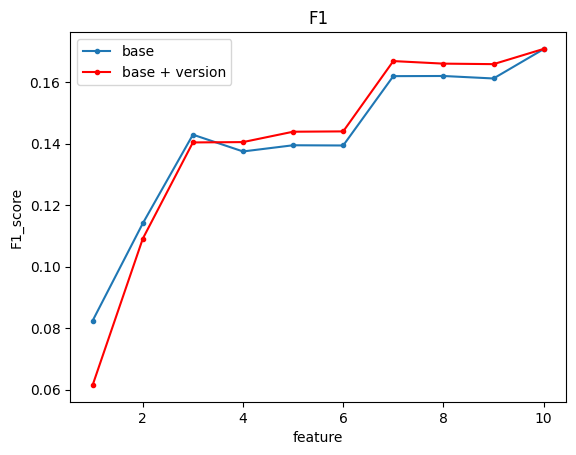

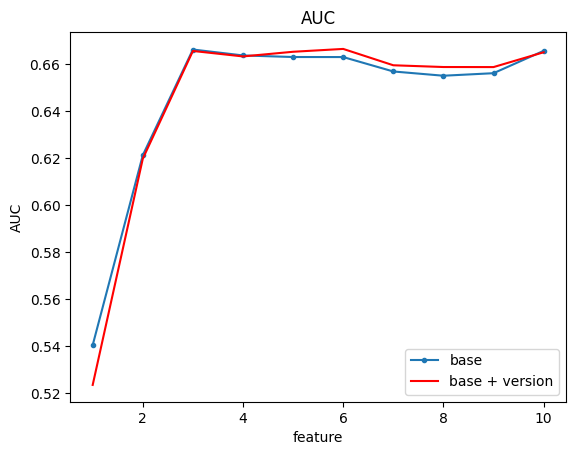

In [3]:
from numpy import array
import numpy as np
import matplotlib.pyplot as plt



base1_score= {'f1': [0.08242424242424243, 0.11404728789986092, 0.14289494575284467, 0.13743589743589743, 0.13944954128440368, 0.1393764736704218, 0.16193274567417565, 0.16198347107438016, 0.16117455138662318, 0.17071569271175313], 'auc': [0.540329180101377, 0.6212104664408792, 0.6662381099460669, 0.6637120011976596, 0.6630410129420297, 0.6630230020634591, 0.6568850479306523, 0.6550725787311706, 0.6561488117546401, 0.6656568439677992], 'feature': [array(['variablesQty_x'], dtype=object), array(['loc_x', 'variablesQty_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loc_x parametersQty_x'],
      dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x',
       'loc_x parametersQty_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x',
       'loc_x parametersQty_x', 'variablesQty_x parametersQty_x'],
      dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x',
       'fanout_x variablesQty_x', 'loc_x parametersQty_x',
       'variablesQty_x parametersQty_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x',
       'fanout_x variablesQty_x', 'wmc_x parametersQty_x',
       'loc_x parametersQty_x', 'variablesQty_x parametersQty_x'],
      dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x',
       'fanout_x variablesQty_x', 'wmc_x parametersQty_x',
       'loc_x parametersQty_x', 'variablesQty_x^2',
       'variablesQty_x parametersQty_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x', 'fanout_x loc_x',
       'fanout_x variablesQty_x', 'wmc_x parametersQty_x',
       'loc_x parametersQty_x', 'variablesQty_x^2',
       'variablesQty_x parametersQty_x'], dtype=object)]}
add1_score= {'f1': [0.026915113871635612, 0.15413455530097897, 0.16206428248076052, 0.20076481835564053, 0.19721952796637568, 0.24089635854341737, 0.2535087719298246, 0.24817518248175183, 0.25524319500223114, 0.2555066079295154], 'auc': [0.5069865092132668, 0.7288570807405972, 0.7236874604175816, 0.7043307349128234, 0.6975537267062498, 0.7000300564519694, 0.69338354408616, 0.6929422775611789, 0.6915800803259636, 0.6941918237764546], 'feature': [array(['LAA_x^2'], dtype=object), array(['ATFD_x', 'LAA_x^2'], dtype=object), array(['variablesQty_x', 'ATFD_x', 'LAA_x^2'], dtype=object), array(['loc_x', 'variablesQty_x', 'ATFD_x', 'LAA_x^2'], dtype=object), array(['loc_x', 'variablesQty_x', 'ATFD_x', 'ATFD_x LAA_x', 'LAA_x^2'],
      dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'ATFD_x', 'ATFD_x LAA_x',
       'LAA_x^2'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'ATFD_x',
       'loc_x parametersQty_x', 'ATFD_x LAA_x', 'LAA_x^2'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'ATFD_x',
       'loc_x parametersQty_x', 'parametersQty_x ATFD_x', 'ATFD_x LAA_x',
       'LAA_x^2'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x', 'ATFD_x',
       'loc_x parametersQty_x', 'parametersQty_x ATFD_x', 'ATFD_x LAA_x',
       'LAA_x^2'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x', 'ATFD_x',
       'loc_x parametersQty_x', 'variablesQty_x parametersQty_x',
       'parametersQty_x ATFD_x', 'ATFD_x LAA_x', 'LAA_x^2'], dtype=object)]}
baseVersion1_score=  {'f1': [0.061491160645657184, 0.10907156158552807, 0.14036911879386535, 0.14048059149722736, 0.1438539989264627, 0.14396161023727005, 0.16683283482884678, 0.16600265604249667, 0.16583747927031509, 0.17078799868117375], 'auc': [0.5233617700835986, 0.6197335743980853, 0.6656257400746646, 0.6632931652420189, 0.6652789476333067, 0.6664902622460561, 0.659526017544384, 0.6587807759290868, 0.6587537596112307, 0.6650556893810671], 'feature': [array(['variablesQty_x'], dtype=object), array(['loc_x', 'variablesQty_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loc_x parametersQty_x'],
      dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x',
       'loc_x parametersQty_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x',
       'loc_x parametersQty_x', 'variablesQty_x parametersQty_x'],
      dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x',
       'fanout_x variablesQty_x', 'loc_x parametersQty_x',
       'variablesQty_x parametersQty_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x',
       'fanout_x variablesQty_x', 'wmc_x parametersQty_x',
       'loc_x parametersQty_x', 'variablesQty_x parametersQty_x'],
      dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x',
       'fanout_x variablesQty_x', 'wmc_x parametersQty_x',
       'loc_x parametersQty_x', 'variablesQty_x^2',
       'variablesQty_x parametersQty_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x', 'fanout_x loc_x',
       'fanout_x variablesQty_x', 'wmc_x parametersQty_x',
       'loc_x parametersQty_x', 'variablesQty_x^2',
       'variablesQty_x parametersQty_x'], dtype=object)]}
addVersion1_score= {'f1': [0.02688728024819028, 0.15302124149309135, 0.16099210822998872, 0.19840510366826156, 0.19714656290531776, 0.2400322190898107, 0.25396825396825395, 0.25, 0.25398230088495577, 0.2545931758530184], 'auc': [0.5069775037739817, 0.7291430449523428, 0.7228161426522897, 0.7014848500409141, 0.6969165503623763, 0.6980194675882104, 0.6927733840601424, 0.6930953700290295, 0.6921272022769839, 0.6947659620453307], 'feature': [array(['LAA_x^2'], dtype=object), array(['ATFD_x', 'LAA_x^2'], dtype=object), array(['variablesQty_x', 'ATFD_x', 'LAA_x^2'], dtype=object), array(['loc_x', 'variablesQty_x', 'ATFD_x', 'LAA_x^2'], dtype=object), array(['loc_x', 'variablesQty_x', 'ATFD_x', 'ATFD_x LAA_x', 'LAA_x^2'],
      dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'ATFD_x', 'ATFD_x LAA_x',
       'LAA_x^2'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'ATFD_x',
       'loc_x parametersQty_x', 'ATFD_x LAA_x', 'LAA_x^2'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'ATFD_x',
       'loc_x parametersQty_x', 'parametersQty_x ATFD_x', 'ATFD_x LAA_x',
       'LAA_x^2'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x', 'ATFD_x',
       'loc_x parametersQty_x', 'parametersQty_x ATFD_x', 'ATFD_x LAA_x',
       'LAA_x^2'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x', 'ATFD_x',
       'loc_x parametersQty_x', 'variablesQty_x parametersQty_x',
       'parametersQty_x ATFD_x', 'ATFD_x LAA_x', 'LAA_x^2'], dtype=object)]}

factors=["f1","auc","feature"]
for factor in factors:
    print(factor)
    print("base : ",base1_score[factor][4])
    print("add : ",add1_score[factor][4])
    print("baseVersion : ",baseVersion1_score[factor][4])
    
x=np.arange(1,11,1)
plt.title("F1")
plt.xlabel("feature")
plt.ylabel("F1_score")
plt.plot(x,base1_score["f1"],label="base",marker=".")
#plt.plot(x,add1_score["f1"],label="add",marker=".")
plt.plot(x,baseVersion1_score["f1"],label="base + version",marker=".",color="red")
#plt.plot(x,addVersion1_score["f1"],label="addVersion",linestyle="dashed",marker="v")
plt.legend()
plt.show()

plt.title("AUC")
plt.xlabel("feature")
plt.ylabel("AUC")
plt.plot(x,base1_score["auc"],label="base",marker=".")
#plt.plot(x,add_score["auc"],label="add",marker=".")
plt.plot(x,baseVersion1_score["auc"],label="base + version",color="red")
#plt.plot(x,addVersion1_score["auc"],label="addVersion",linestyle="dashdot",marker="v")
plt.legend()
plt.show()